In [1]:
## generate.ipynb
## Code to generate a Gaussian Random Field for velocities as a standard model for cloud
## scale star formation simulations. The field is guaranteed to be solenoidal.

import numpy as np
import h5py
import matplotlib.pyplot as plt
from generate import init_velocity_field

In [2]:
# Example usage
N = 128
sigma = 1.0
kspec = 2
kmin = 2
kmax = 16
# Lorentz's Birthday: 18th of July, 1853
seed = 18071853


(vx,vy,vz) = init_velocity_field(sigma, kspec, kmin, kmax, N, seed=seed)

The velocity field is meant to just encompass the whole cloud being considered. We show a slice of the x-component of the velocity field below with the edge of the cloud inscribed. When setting up the $\texttt{unicloud}^{\rm TM}$ initial conditions, one should set to zero all velocities which lie outside the cloud (outside the white circle below, but in 3D).

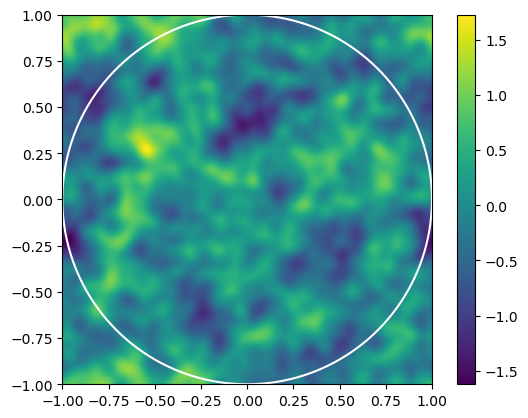

In [3]:
plt.imshow(vx[N//2],extent=(-1,1,-1,1))
plt.colorbar()

t = np.linspace(0,2*np.pi, 1000)
x = np.cos(t)
y = np.sin(t)
plt.plot(x,y,'w')